In [132]:
using Revise
using MajoranaPropagation
using PauliPropagation

using Plots 
using LaTeXStrings
using TimerOutputs
using ProgressMeter

Simulate the dynamics of the spinful Hubbard model on a 2D lattice of $N_x \times N_y$ spinful sites. The Hamiltonian is
$$\hat{H}=-t \sum_{\langle i,j\rangle, \sigma=\{\uparrow, \downarrow\}}\left(\hat{c}_{i, \sigma}^{\dagger} \hat{c}_{j, \sigma}+\hat{c}_{j, \sigma}^{\dagger} \hat{c}_{i, \sigma}\right)+U \sum_i \hat{n}_{i \uparrow} \hat{n}_{i \downarrow}$$

In [133]:
N_x = 4
N_y = 4
N_spinful_sites = N_x * N_y
t = 1.
U = 2.

n_layers = 12
dt = 0.07

0.07

Get 1D connectivity, and create the circtuit for implementing a single layer of first order Trotterization.

In [134]:
topo = rectangletopology(N_x, N_y)
circ_single, thetas_single, mps_circ_single, mps_thetas_single = hubbard_circ_fermionic_sites(topo, N_spinful_sites, 1, t, U, dt; return_mps_instructions=true);

#### Set the truncations
1. `min_abs_coeff`: PP coefficient truncation
2. `W`: weight truncation (aka monomial truncation)
3. `max_singles`: number of unpaired Majoranas, namely the number of indices $i$ where only one of $\gamma_i$, $\gamma'_i$ are non-zero
4. `max_sins`: PP truncation for dynamics

In [135]:
min_abs_coeff = 1.e-5
W = Inf
max_singles = 6
max_sins = Inf

max_single_filter = create_max_single_filter(2 * N_spinful_sites)
custom_trunc = let max_single_filter=max_single_filter, max_singles = max_singles
    (mstr, coeff) -> (compute_max_single(mstr, 0, max_single_filter) > max_singles)
end

#19 (generic function with 1 method)

Set the inital state as the checkerboard state $\ket{\uparrow\downarrow\cdots\uparrow\downarrow}$

In [136]:
#initial state 
initial_state_label = "Checkerboard"

create_up_part_at = []
create_down_part_at = []

for j=1:N_spinful_sites 
    if j % 2 == 1
        push!(create_up_part_at, j)
    else 
        push!(create_down_part_at, j)
    end 
end

@show create_up_part_at
@show create_down_part_at

create_up_part_at = Any[1, 3, 5, 7, 9, 11, 13, 15]
create_down_part_at = Any[2, 4, 6, 8, 10, 12, 14, 16]


8-element Vector{Any}:
  2
  4
  6
  8
 10
 12
 14
 16

Backpropagate $n_{2,\uparrow}$, the up density on site 2

In [137]:
to = TimerOutput()

site_index = 3
obs, obs_pref = spinful_ms_and_pref_from_symbol(N_spinful_sites, :nund, site_index)
obs = wrapcoefficients(obs, MajoranaFrequencyTracker)

@show obs 

res = zeros(n_layers+1)
res[1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites; add_pref=obs_pref)
length_res = zeros(n_layers+1)
length_res[1] = length(obs)

@showprogress for k=1:n_layers
    @timeit to "propagate" propagate!(circ_single, obs, thetas_single, min_abs_coeff=min_abs_coeff, max_weight=W, max_sins=max_sins, customtruncfunc=custom_trunc)
    @timeit to "evaluate" res[k+1] = overlap_with_fock_spinful(obs, create_up_part_at, create_down_part_at, 2 * N_spinful_sites; add_pref=obs_pref)
    length_res[k+1] = length(obs)
end 

to

obs = MajoranaSum with 3 term(s):(
    MajoranaFrequencyTracker{Float64}(coeff=0.25, freq=0, nsins=0, ncos=0) * 0000000011000000000000000000000000000000000000000000000000000000
    MajoranaFrequencyTracker{Float64}(coeff=-0.25, freq=0, nsins=0, ncos=0) * 0000000011110000000000000000000000000000000000000000000000000000
    MajoranaFrequencyTracker{Float64}(coeff=0.25, freq=0, nsins=0, ncos=0) * 0000000000110000000000000000000000000000000000000000000000000000)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


──────────────────────────────────────────────────────────────────────
                             Time                    Allocations      
                    ───────────────────────   ────────────────────────
 Tot / % measured:       13.7s /  99.8%           1.16GiB /  99.9%    

Section     ncalls     time    %tot     avg     alloc    %tot      avg
──────────────────────────────────────────────────────────────────────
propagate       12    13.5s   98.6%   1.12s    912MiB   76.5%  76.0MiB
evaluate        12    191ms    1.4%  15.9ms    279MiB   23.5%  23.3MiB
──────────────────────────────────────────────────────────────────────

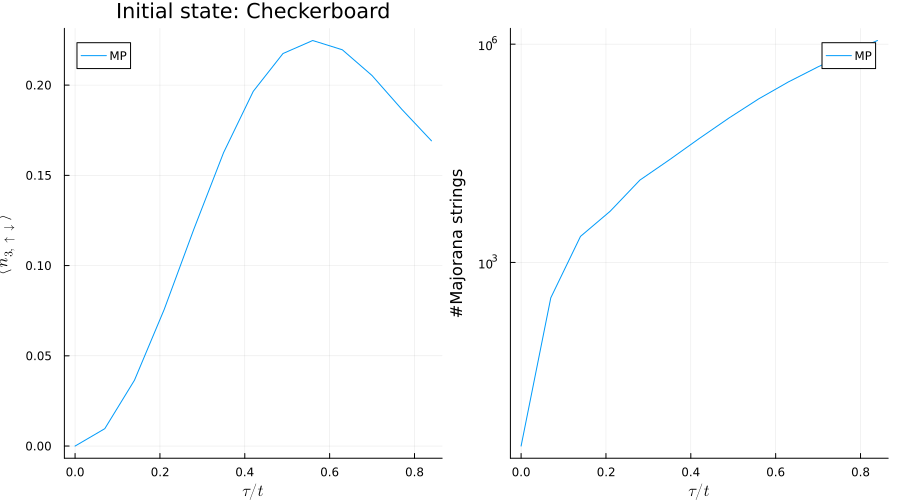

In [138]:
p_res = plot(dt*(0:n_layers)./ t, res, label="MP", xlabel=L"\tau/t", ylabel=L"\langle n_{%$site_index,\uparrow\downarrow}\rangle", title = "Initial state: " * initial_state_label)
p_length = plot(dt*(0:n_layers)./ t, length_res, label="MP", xlabel=L"\tau/t", ylabel="#Majorana strings", yscale=:log10)    

plot(p_res, p_length, layout=(1,2), size=(900,500))